In [1]:
import numpy as np
import sys
import time
import os
import h5py
import os.path as op
import matplotlib.cm as cm
from matplotlib.widgets import Slider, Button, RadioButtons
import matplotlib.pyplot as plt
import array
%matplotlib inline
sys.path.append('..')
from zwatershed import *
from visualization.visualize_funcs import *
from edgelist_methods import *
path_to_folder = '/Users/chandansingh/drive/janelia/conv_net_scripts/'
path_to_data = path_to_folder + 'data/'
from multiprocessing import Pool

# -------------------------------- parameters ---------------------------------------
pred_file = '/groups/turaga/home/turagas/research/caffe_v2/processed/bock2/120000/sample_A_x1_y1_z1_xy1.h5'
pred_file_2 = '/groups/turaga/home/turagas/research/caffe_v2/processed/bock2/120000/cutout_3k.h5'
out_folder = '/nobackup/turaga/singhc/par_zwshed/'
threshes = [2000]
cmap = matplotlib.colors.ListedColormap(np.vstack(((0, 0, 0), np.random.rand(255, 3))))
NUM_WORKERS = 4

In [3]:
f = h5py.File(pred_file, 'r') # only key is main
preds = f['main']
print preds.shape

(3, 125, 1250, 1250)


# Divide Volumes, set up args

In [4]:
def zwshed_h5_par(arg):
    (pred_vol,threshes,seg_save_path) = arg
    print "calculating",seg_save_path,"watershed"
    zwatershed_h5(pred_vol, threshes,seg_save_path)
    print "finished",seg_save_path,"watershed"
def dim_to_name(start):
    return str(start[0])+'_'+str(start[1])+'_'+str(start[2])+'/'

In [5]:
MAX_LEN = 400
dims = np.array((preds.shape[1:]))
print "dims",dims # x,y,z
num_vols = np.array([int(x/MAX_LEN)+1 for x in dims])
deltas = dims/num_vols
print "num_vols",num_vols
print "deltas",deltas
starts = []
ends = []
for x in range(num_vols[0]):
    for y in range(num_vols[1]):
        for z in range(num_vols[2]):
            starts.append((x,y,z)*deltas)
            extra = 3*np.array([x==num_vols[0]-1,y==num_vols[1]-1,z==num_vols[2]-1],dtype='int')
            ends.append((x,y,z)*deltas + deltas + [1,1,1]+extra)
args = []
for i in range(4): # len(starts)):
    s = starts[i]
    e = ends[i]
    pred_vol = preds[:,s[0]:e[0],s[1]:e[1],s[2]:e[2]]
    print s,e,pred_vol.shape
    args.append((pred_vol,threshes,out_folder+dim_to_name(s)))    

dims [ 125 1250 1250]
num_vols [1 4 4]
deltas [125 312 312]
[0 0 0] [129 313 313] (3, 125, 313, 313)
[  0   0 312] [129 313 625] (3, 125, 313, 313)
[  0   0 624] [129 313 937] (3, 125, 313, 313)
[  0   0 936] [ 129  313 1252] (3, 125, 313, 314)


# Call Watershed

In [8]:
p = Pool(NUM_WORKERS)
p.map(zwshed_h5_par, args)

calculating /nobackup/turaga/singhc/par_zwshed/0_0_0/ watershed
calculating /nobackup/turaga/singhc/par_zwshed/0_0_312/ watershed
calculating /nobackup/turaga/singhc/par_zwshed/0_0_624/ watershed
calculating /nobackup/turaga/singhc/par_zwshed/0_0_936/ watershed
finishedfinishedfinishedfinished /nobackup/turaga/singhc/par_zwshed/0_0_0/ watershed
 /nobackup/turaga/singhc/par_zwshed/0_0_312/ watershed
 /nobackup/turaga/singhc/par_zwshed/0_0_624/ watershed
 /nobackup/turaga/singhc/par_zwshed/0_0_936/ watershed


[None, None, None, None]

# Stitch

calculating zbars...
zbar shape (125, 313, 1250)
	[0 0 0] [129 313 313] (125, 313, 313) 1409
	[  0   0 312] [129 313 625] (125, 313, 313) 2954
	[  0   0 624] [129 313 937] (125, 313, 313) 4860
	[  0   0 936] [ 129  313 1252] (125, 313, 314) 6598
merging numbers, 1030 keys ... 
	nsegs before 6598


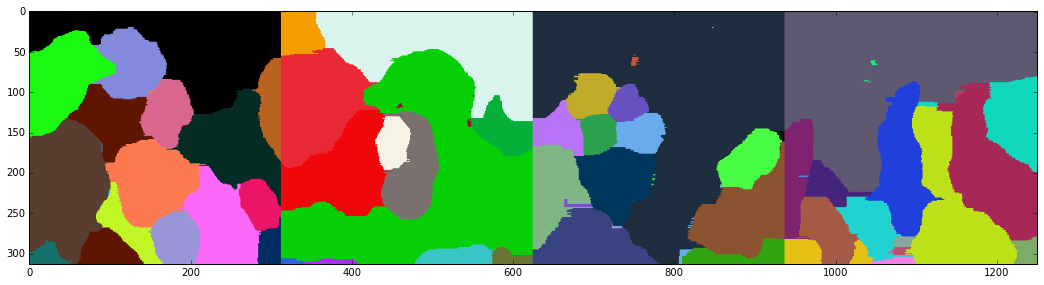

	nsegs after 5568


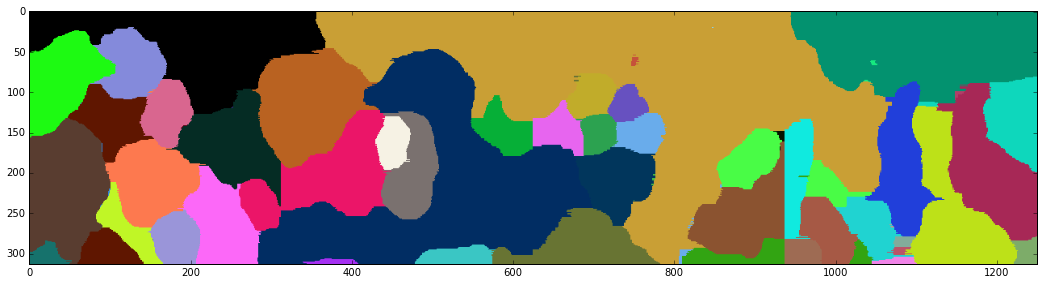

	renumbering all... 6598
	num segs 5568


/groups/turaga/home/singhc/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:27: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


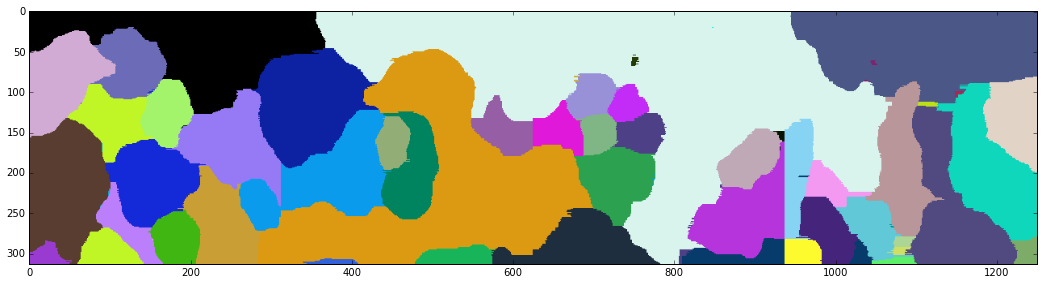

calculating ybars...


In [17]:
# todo - have this support several threshes
print "calculating zbars..."
i = 0
zbars = {}
for x in range(1): #num_vols[0]):
    for y in range(1): #num_vols[1]):
        xdim,ydim = deltas[0]+1,deltas[1]+1
        if x==num_vols[0]-1:
            xdim = dims[0]-deltas[0]*(num_vols[0]-1)
        if y==num_vols[1]-1:
            xdim = dims[1]-deltas[1]*(num_vols[1]-1)
        zbar = np.zeros((xdim,ydim,dims[2]),dtype='uint64')
        print "zbar shape",zbar.shape
        renums = {} # maxes -> mins
        for z in range(4): #num_vols[2]):
            # merge along z axis - fills in zbar
            inc_max = np.max(zbar)
            arg = args[i]
            s = starts[i]
            e = ends[i]
            # for filename in os.listdir(arg[2]):
            filename = 'seg_2000.h5'
            seg_h5 = h5py.File(arg[2]+filename,'r')
            seg = seg_h5['main']+inc_max
            if z==0: # don't merge
                zbar[:,:,s[2]:e[2]] = seg[:,:,:]
            else: # merge
                edge_old = zbar[:,:,s[2]].flatten()
                edge_new = seg[:,:,0].flatten()
                
                #print "\tedge_old:",edge_old[0:100]
                #print "\tedge_new:",edge_new[0:100]
                '''
                hist1,s1 = prune_and_renum(edge_old)
                hist2,s2 = prune_and_renum(edge_new)
                print "num_back",sum(edge_old==1),sum(edge_new==1)
                plt.subplot(311)
#                 plt.hist(hist1)
                plt.plot(s1)
                plt.subplot(312)
#                 plt.hist(hist2)
                plt.plot(s2)
                plt.subplot(313)
                plt.plot(np.subtract(s1,s2[:316]))
                print "max diff",max(np.subtract(s1,s2[:316]))
                plt.show()
                print sum(hist1-hist2)
                '''
                edge_mins = np.minimum(edge_old,edge_new)
                edge_maxes = np.maximum(edge_old,edge_new)
                
                
                for j in range(len(edge_mins)):
                    edge_min = edge_mins[j]
                    edge_max = edge_maxes[j]
                    if not edge_max==edge_min:
                        
                        while edge_min in renums:
                            edge_min = renums[edge_min]   
                        '''
                        if edge_max in renums: # already in map
                            old_min = renums[edge_max]
                            merge_max = max(old_min,edge_min)
                            merge_min = min(old_min,edge_min)
                            if not merge_max==merge_min: # merge the two segments it is pointing to
                                renums[merge_max] = merge_min
                            edge_min = merge_min
                        '''                 
                        renums[edge_max] = edge_min

                zbar[:,:,s[2]:e[2]] = seg[:,:,:]
            print "\t",s,e,seg.shape, np.max(zbar)
            i+=1
            
        # merge numbers
        print "merging numbers,",len(renums.keys()),"keys ... "            
        
        print "\tnsegs before",len(np.unique(zbar))
        display_seg_z(zbar,1)
        mp = np.arange(0,np.max(zbar)+1,dtype='uint64')
        mp[renums.keys()] = renums.values()
        zbar = mp[zbar]
        print "\tnsegs after",len(np.unique(zbar))
        display_seg_z(zbar,1)
        
        # renumber all
        print "\trenumbering all...",np.max(zbar)
        zbar,seg_sizes = prune_and_renum(zbar,0)
        print "\tnum segs",np.max(zbar)
        # zbars[(x,y)] = zbar  
        display_seg_z(zbar,1)
        
print "calculating ybars..."
'''
for key in zbars:
    bar = zbars[key]
    display_seg_z(bar,1)
'''
seg_out = np.zeros(dims,dtype='uint64') # x,y,z   


# Visualize

In [136]:
for arg in args:
    for filename in os.listdir(arg[2]):
        seg_h5 = h5py.File(arg[2]+filename,'r')
        seg = seg_h5['main']
        print arg[2],seg.shape

/nobackup/turaga/singhc/par_zwshed/0_0_0/ (125, 313, 313)
/nobackup/turaga/singhc/par_zwshed/0_0_312/ (125, 313, 313)


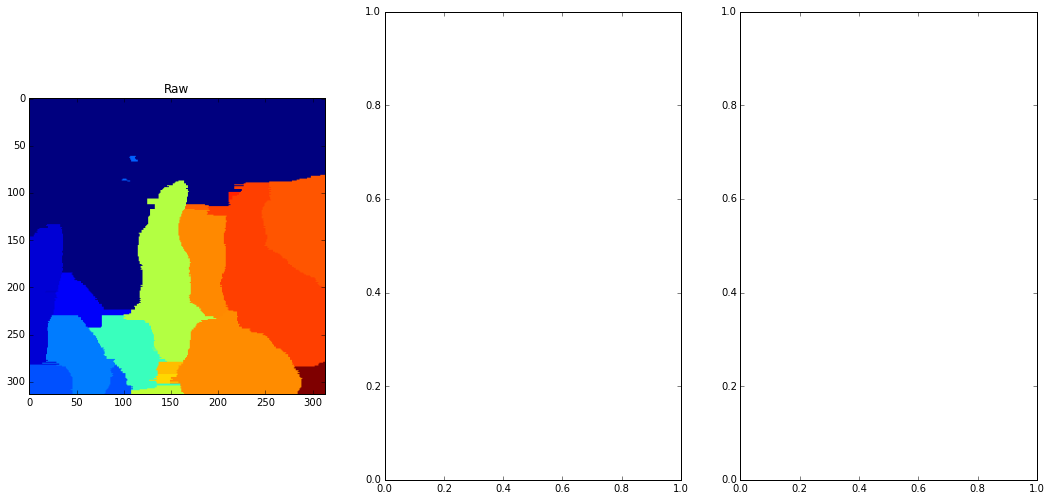

In [16]:
def display_affs(raw, label, seg):
    fig = plt.figure(figsize=(20, 10))
    fig.set_facecolor('white')
    ax1, ax2, ax3 = fig.add_subplot(1, 3, 1), fig.add_subplot(1, 3, 2), fig.add_subplot(1, 3, 3)
    fig.subplots_adjust(left=0.2, bottom=0.25)
    ax1.imshow(np.transpose(raw[:, :, :, 1],(2,1,0)))
    ax1.set_title('Raw')
    plt.show()
def display_segs(raw, label, seg):
    fig = plt.figure(figsize=(20, 10))
    fig.set_facecolor('white')
    ax1, ax2, ax3 = fig.add_subplot(1, 3, 1), fig.add_subplot(1, 3, 2), fig.add_subplot(1, 3, 3)
    fig.subplots_adjust(left=0.2, bottom=0.25)
    ax1.imshow(raw[1, :, :])
    ax1.set_title('Raw')
    plt.show()
def display_seg_z(raw,depth=1):
    fig = plt.figure(figsize=(20, 10))
    ax1 = fig.add_subplot(1, 1, 1)
    fig.subplots_adjust(left=0.2, bottom=0.25)
    ax1.imshow(raw[depth, :, :], cmap=cmap)
    plt.show()
def prune_and_renum(seg,sizeThreshold=1):
    # renumber the components in descending order by size
    segId,segSizes = np.unique(seg, return_counts=True)
    renum = np.zeros(segId.max()+1,dtype=np.int32)
    renum[segId] = np.arange(0,len(segId)+1)

    if sizeThreshold>0:
        renum[segId[segSizes<=sizeThreshold]] = 0
        segSizes = segSizes[segSizes>sizeThreshold]

    seg = renum[seg]
    return (seg, segSizes)
# display_arbitrary(preds,preds,preds)
display_segs(seg,seg,seg)